---
# Calculate words per minute for rap, rock, and country songs
---

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image, display
import nltk
from nltk.classify import apply_features
from nltk import word_tokenize
from collections import Counter
import random
import time
import re
from datetime import datetime
from string import punctuation
fs = 16 # fontsize

## Load and format the lyrics JSON object

In [4]:
artists_rap = json.load(open('lyrics/rap_lyrics.json'))

In [5]:
artists_rock = json.load(open('lyrics/rock_lyrics.json'))

In [6]:
artists_country = json.load(open('lyrics/country_lyrics.json'))

In [7]:
artists_raw = artists_rap + artists_rock + artists_country
# artists_raw = artists_rap

In [8]:
def result_is_lyrics(song_title):
    """Returns False if result from Genius is not actually song lyrics"""
    regex = re.compile(
        r"(tracklist)|(track list)|(album art(work)?)|(liner notes)|(booklet)|(credits)", re.IGNORECASE)
    return not regex.search(song_title)

In [9]:
# Determine
def getArtistImage(songs):    
    urls = [None]
    for song in songs:
        if song['raw']['album'] is not None:
            try:                
                urls.append(song['raw']['album']['artist']['image_url'])                
            except:
                pass
    
    return Counter(urls).most_common()[0][0] # Most common image

# Use a generator to exclude artists with too few songs
def filterBySongCount(artists, min_count=10, max_count=10000):
    for artist in artists:        
        num_songs = len(artist['songs'])
        if (num_songs >= min_count) and (num_songs < max_count): yield artist

min_songs, max_songs = 10, 2500
artists = list(filterBySongCount(artists_raw, min_songs, max_songs))

# Artist images
for artist in artists:
    artist['image_url'] = getArtistImage(artist['songs'])
    
    # Kludge
    if artist['artist'] == 'Black Thought':
        artist['image_url'] = 'https://images.genius.com/23de511f4ac50d900128ea363b7d81b3.450x320x1.jpg'
    if artist['artist'] == 'André 3000':
        artist['image_url'] = 'http://images.genius.com/64b15c9489c65f5bf8f6577334347404.434x434x1.jpg'            
        
# Gender
labels_gender = np.array([a['gender'] for a in artists])
mask_female = np.array([g=='female' for g in labels_gender])
mask_male   = np.array([g=='male'   for g in labels_gender])
print("You have lyrics from {} artists, with a minimum of {} songs per artist.\nFemale: {}, male: {}"
      .format(len(artists), min_songs, (labels_gender=='female').sum(), (labels_gender=='male').sum()))

# Add all song lyrics to a single list
all_songs, genres = [], []
for artist, gender in zip(artists, labels_gender):
    for song in artist['songs']:        
        song['gender'] = gender
        if len(song['lyrics'].split(' ')) > 10:
            all_songs.append(song)
            if song['genre'] not in genres:
                genres.append(song['genre'])
              
song_count = len(all_songs)
print("Database contains {} songs.".format(song_count))

# Store all lyrics in a single string
all_lyrics = " ".join([song['lyrics'] for song in all_songs])

You have lyrics from 303 artists, with a minimum of 10 songs per artist.
Female: 79, male: 222
Database contains 56907 songs.


In [10]:
for artist in artists[:3]:
    print(artist['artist'])
    display(Image(url=artist['image_url'], width=100))

2Pac


Eminem


The Notorious B.I.G.


In [75]:
spot_count = 0
total_songs = 0
for artist in artists:
    for song in artist['songs']:
        total_songs += 1
        if len(song['raw']['media']) > 0:
            for m in song['raw']['media']:
                if m['provider'] == 'spotify':
                    spot_count += 1

print("Of the {total} total songs, {spot} of them have Spotify links ({per})".format(total=total_songs, spot=spot_count, per=100*spot_count/total_songs))

Of the 58239 total songs, 13342 of them have Spotify links (22.90904720204674)


---
# Combine the Genius and Spotify data

In [11]:
# Load the Spotify data
spotify_data = json.load(open('./spotify_data.json'))
spotify_data = list(filter(lambda x: len(x['songs'])>0, spotify_data))

In [12]:
def getArtistIndex(artists, artist_name):
    for n,artist in enumerate(artists):
        if artist['artist'].lower() == artist_name.lower():
            return n
    return None

def getSongIndex(songs, song_lyrics):
    """Returns the index of the Genius songs, corresponding to the Spotify song lyrics passed in"""
    for n,song in enumerate(songs):
        if song['lyrics'] == song_lyrics:
            return n
    return None

def searchSongsByAllArtists(artists, lyrics):
    for i,artist in enumerate(artists):
        for j,song in enumerate(artist['songs']):
            if song['lyrics'] == lyrics:
                return i,j
    return None

In [16]:
n=5;

In [17]:
artists[(n-10):] + artists[:n-10];

In [18]:
a = [1,2,3,4,5]
b = [6,7,8]

In [35]:
n = 3
m = 6
a[(n-m):] + a[:(n-m)]

[3, 4, 5, 1, 2]

In [25]:
a[n-4:] + a[:n-4]

[5, 1, 2, 3, 4]

In [37]:
# I think the correct way to do this would be a join table between two dataframes
combined_data = []
m = 10
for n,artist in enumerate(spotify_data):
    name = artist['artist']
    combined_data.append({'artist': name, 'songs': []})
       
    for song in artist['songs']:
        idx_artist, idx_song = searchSongsByAllArtists(artists[(n-m):] + artists[:(n-m)], song['lyrics'])
        idx_artist += (n-m)
        if idx_artist is not None and idx_song is not None:
            genius_artist = artists[idx_artist]['artist']
            genius_title  = artists[idx_artist]['songs'][idx_song]['title']
            spot_artist = song['spotify']['artists'][0]['name']
            spot_title  = song['spotify']['name']

            if (genius_artist.lower()==spot_artist.lower()) and (genius_title.lower()==spot_title.lower()):
                song_genius = artists[idx_artist]['songs'][idx_song]
                new_song_obj = {'title': song['spotify']['name'],
                                              'album': song['spotify']['album']['name'],
                                              'artist': song['spotify']['artists'][0]['name'],                                      
                                              'image': song['spotify']['album']['images'][0]['url'],
                                              'lyrics': song['lyrics'],
                                              'duration': song['spotify']['duration_ms'],
                                              'gender': song_genius['gender'],
                                              'genre': song_genius['genre'],
                                              'genius': song_genius['raw'],
                                              'spotify': song['spotify']}
                if new_song_obj not in combined_data[-1]['songs']:
                    combined_data[-1]['songs'].append(new_song_obj)
    if n%10==0:
        print("{:3.0f}/{:3.0f}".format(n,len(spotify_data)))

  0/302
 10/302
 20/302
 30/302
 40/302
 50/302
 60/302
 70/302
 80/302
 90/302
100/302
110/302
120/302
130/302
140/302
150/302
160/302
170/302
180/302
190/302
200/302
210/302
220/302
230/302
240/302
250/302
260/302
270/302
280/302
290/302
300/302


---
# Words per minute

In [38]:
# Song durations
all_songs = []
for artist in combined_data:
    for song in artist['songs']:
        duration = song['spotify']['duration_ms']/1000
        if duration is not None:
            song['duration'] = duration
            all_songs.append(song)
            
print("{n} songs have Spotify data.".format(n=len(all_songs)))

23863 songs have Spotify data.


### Calculate word counts

In [40]:
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

In [72]:
song['duration']/60

3.38955

In [73]:
# Calculate word counts, words per minute, and lexical diversity
unique = False
m = 600 if unique else 800
word_counts, wpm, lexdivs = [],[],[]
songs_with_wc = []
durations = []
for song in all_songs:
    
    if 'instrumental' not in song['title'].lower():
        lyrics = clean_str(song['lyrics'])   

        # Count the words in the song's lyrics
        words = list(filter(lambda x: x!="", clean_str(lyrics.replace('\n',' ')).split(' ')))

        if len(words) < m and len(words) > 10 and song['duration'] > 10: # Get rid of outliers
            # Word counts (unique or total)
            wc = len(set(words)) if unique else len(words)
            word_counts.append(wc)
            song['word_count'] = word_counts[-1]

            # Lexical diversity
            if wc > 0:
                lexdivs.append(len((set(words)))/len(words))
                song['lexdiv'] = lexdivs[-1]

            # Calculate words per minute for each song            
            wpm.append(word_counts[-1]/song['duration']*60)
            song['wpm'] = wpm[-1]

            # New list of just songs with a word count
            songs_with_wc.append(song)
            
            durations.append(song['duration']/60)
            
wpm = np.array(wpm)

In [74]:
durations = np.array(durations)

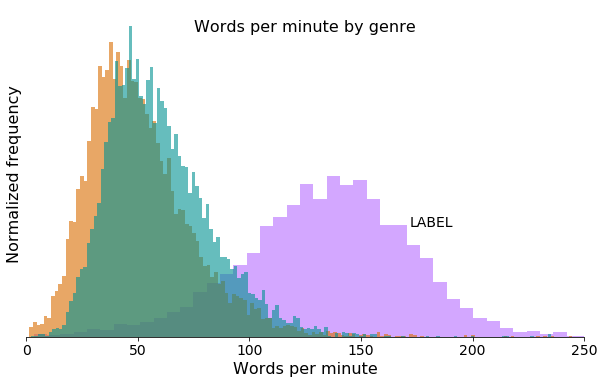

In [162]:
# Options for the plot
norm = True
save = False

# Plot the histogram of words per minute
# colors = ['red','orange','blue']
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
genres = ['rap','rock','country']
fig, ax = plt.subplots(figsize=(10,6))
for g, c in zip(genres, colors):
    mask_genre = np.array([n for n,song in enumerate(songs_with_wc) if song['genre']==g])
    if len(mask_genre) > 0:
        ax.hist(wpm[mask_genre], 250, color=c, alpha=0.6, label=g, normed=norm)

# Touch up the plot
FS = 16
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0, 250])
if unique:
    ax.set_xlabel("Unique words per minute", fontsize=FS)
    title = "Unique words per minute by genre"
else:
    ax.set_xlabel("Words per minute", fontsize=FS)    
    title = "Words per minute by genre"        
if norm:
    ax.set_ylabel("Normalized frequency", fontsize=FS)
    ax.get_yaxis().set_ticks([])
    ax.spines['left'].set_visible(False)
else:    
    ax.set_ylabel("Number of songs", fontsize=FS)    
ax.text(0.5, 0.95, title, fontsize=FS,
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')
# ax.legend(loc=(0.8,0.4), edgecolor='k', fontsize=FS-4)

label_locs = [[15,0.02], [70,0.013], [172, 0.008]]
ax.text(label_locs[2][0], label_locs[2][1], 'LABEL', fontsize=FS-2)

if save:
    filename = "Histogram_WordsPerMinuteByGenre"
    if norm:
        filename += "_normalized"
    if unique:
        filename += "_unique"
    plt.savefig("./figures/" + filename + ".png", format='png', dpi=300, bbox_inches='tight')
    print(filename)
else:
    plt.show()

## Histogram of song durations

Histogram_SongDurationsByGenre_normalized


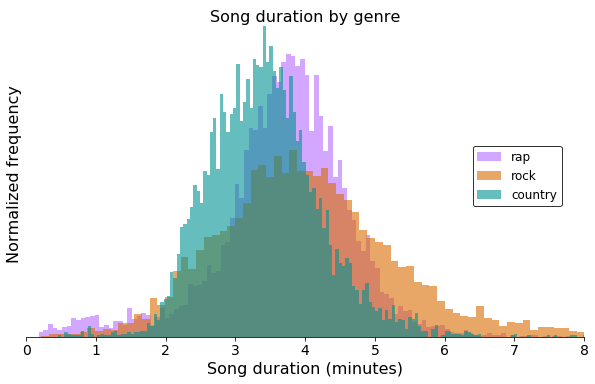

In [80]:
# Options for the plot
norm = True
save = False

# Plot the histogram of words per minute
# colors = ['red','orange','blue']
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
genres = ['rap','rock','country']
fig, ax = plt.subplots(figsize=(10,6))
for g, c in zip(genres, colors):
    mask_genre = np.array([n for n,song in enumerate(songs_with_wc) if song['genre']==g])
    if len(mask_genre) > 0:
        ax.hist(durations[mask_genre], 250, color=c, alpha=0.6, label=g, normed=norm)

# Touch up the plot
FS = 16
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([0, 250])
ax.set_xlim([0, 8])
ax.set_xlabel("Song duration (minutes)", fontsize=FS)    
title = "Song duration by genre"        
if norm:
    ax.set_ylabel("Normalized frequency", fontsize=FS)
    ax.get_yaxis().set_ticks([])
    ax.spines['left'].set_visible(False)
else:    
    ax.set_ylabel("Number of songs", fontsize=FS)    
ax.text(0.5, 0.98, title, fontsize=FS,
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='center')
ax.legend(loc=(0.8,0.4), edgecolor='k', fontsize=FS-4)

if save:
    filename = "Histogram_SongDurationsByGenre"
    if norm:
        filename += "_normalized"
    plt.savefig("./figures/" + filename + ".png", format='png', dpi=300, bbox_inches='tight')
    print(filename)
else:
    plt.show()

Histograms_WordsPerMinute_and_SongDurations_ByGenre_normalized


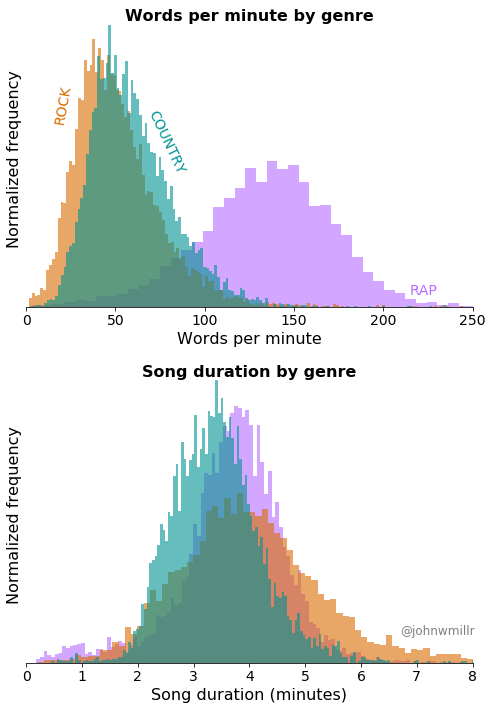

In [205]:
# Options for the plot
norm = True
save = True

# Plot the histogram of words per minute
# colors = ['red','orange','blue']
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
genres = ['rap','rock','country']
fig, axs = plt.subplots(nrows=2, figsize=(8,12))
label_locs = [[215, 0.001], [15,0.017], [67, 0.015]]
rots = [0,80,-65]
for ax,dat in zip(axs,[wpm,durations]):
    j = 0
    for g, c in zip(genres, colors):
        mask_genre = np.array([n for n,song in enumerate(songs_with_wc) if song['genre']==g])
        if len(mask_genre) > 0:
            ax.hist(dat[mask_genre], 250, color=c, alpha=0.6, label=g, normed=norm)        
            
        if ax == axs[0]:
            ax.text(label_locs[j][0], label_locs[j][1], g.upper() , fontsize=FS-2, color=c, rotation=rots[j])
            j += 1

    # Touch up the plot
    FS = 16
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if ax == axs[0]:
        ax.set_xlim([0, 250])
        ax.set_xlabel("Words per minute", fontsize=FS)    
        title = "Words per minute by genre"        
    else:
        ax.set_xlim([0, 8])
        ax.set_xlabel("Song duration (minutes)", fontsize=FS)    
        title = "Song duration by genre"        
        ax.annotate("@johnwmillr", (6.7,0.06), fontsize=FS-4, alpha=0.5)
    if norm:
        ax.set_ylabel("Normalized frequency", fontsize=FS)
        ax.get_yaxis().set_ticks([])
        ax.spines['left'].set_visible(False)
    else:    
        ax.set_ylabel("Number of songs", fontsize=FS)    
    ax.text(0.5, 0.98, title, fontsize=FS,
            transform=ax.transAxes, verticalalignment='center', horizontalalignment='center', weight='bold')        
    

if save:
    filename = "Histograms_WordsPerMinute_and_SongDurations_ByGenre"
    if norm:
        filename += "_normalized"
    plt.savefig("./figures/" + filename + ".png", format='png', dpi=300, bbox_inches='tight')
    print(filename)
else:
    plt.show()

---
# Release date data

In [122]:
songs_with_year = []
wpm_with_year = []
for n,song in enumerate(songs_with_wc):
    date = song['spotify']['album']['release_date']
    if len(date) == 4:
        d = datetime.strptime(date, '%Y')
    elif len(date) == 7:
        d = datetime.strptime(date, '%Y-%M')
    else:
        d = datetime.strptime(date, '%Y-%M-%d')
    if (d.year>=1900 and d.year<=2018): # kludge for correct parsing of date
        song['date'] = d
        songs_with_year.append(song)
        wpm_with_year.append(wpm[n])

print("{:.1f}% of songs have date information, for a total of {} songs.".format(100*len(songs_with_year)/len(songs_with_wc),len(songs_with_year)))

100.0% of songs have date information, for a total of 23135 songs.


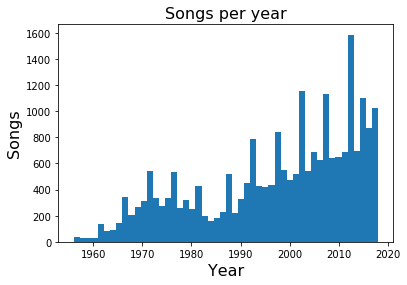

In [88]:
# Kludge to sort the songs by year
years = np.array(list(map(lambda d: d.year, [s['date'] for s in songs_with_year])))
songs_with_year = np.array([x for _, x in sorted(zip(years, songs_with_year), key=lambda pair: pair[0])])
years.sort()

# Distribution of the years
plt.hist(years, 50)
plt.xlabel("Year", fontsize=FS)
plt.ylabel("Songs", fontsize=FS)
plt.title("Songs per year",fontsize=FS)
plt.show()

## Words per minute over time

In [89]:
def fitLine(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    soln = np.linalg.lstsq(A, y, rcond=None)[0]    
    
    # residual sum of squares
    y_fit = soln[0]*x + soln[1]
    ss_res = np.sum((y - y_fit)**2) # residuals ?
    ss_tot = np.sum((y - y.mean())**2) # total sum of squares
    r2 = round(1 - (ss_res / ss_tot), 3) # r-squared
        
    return y_fit, x, r2

In [135]:
songs_with_year[-1]['date']

datetime.datetime(2014, 1, 1, 0, 1)

In [132]:
songs_w_year[-1]['genre']

'rock'

In [136]:
len(years)

7164

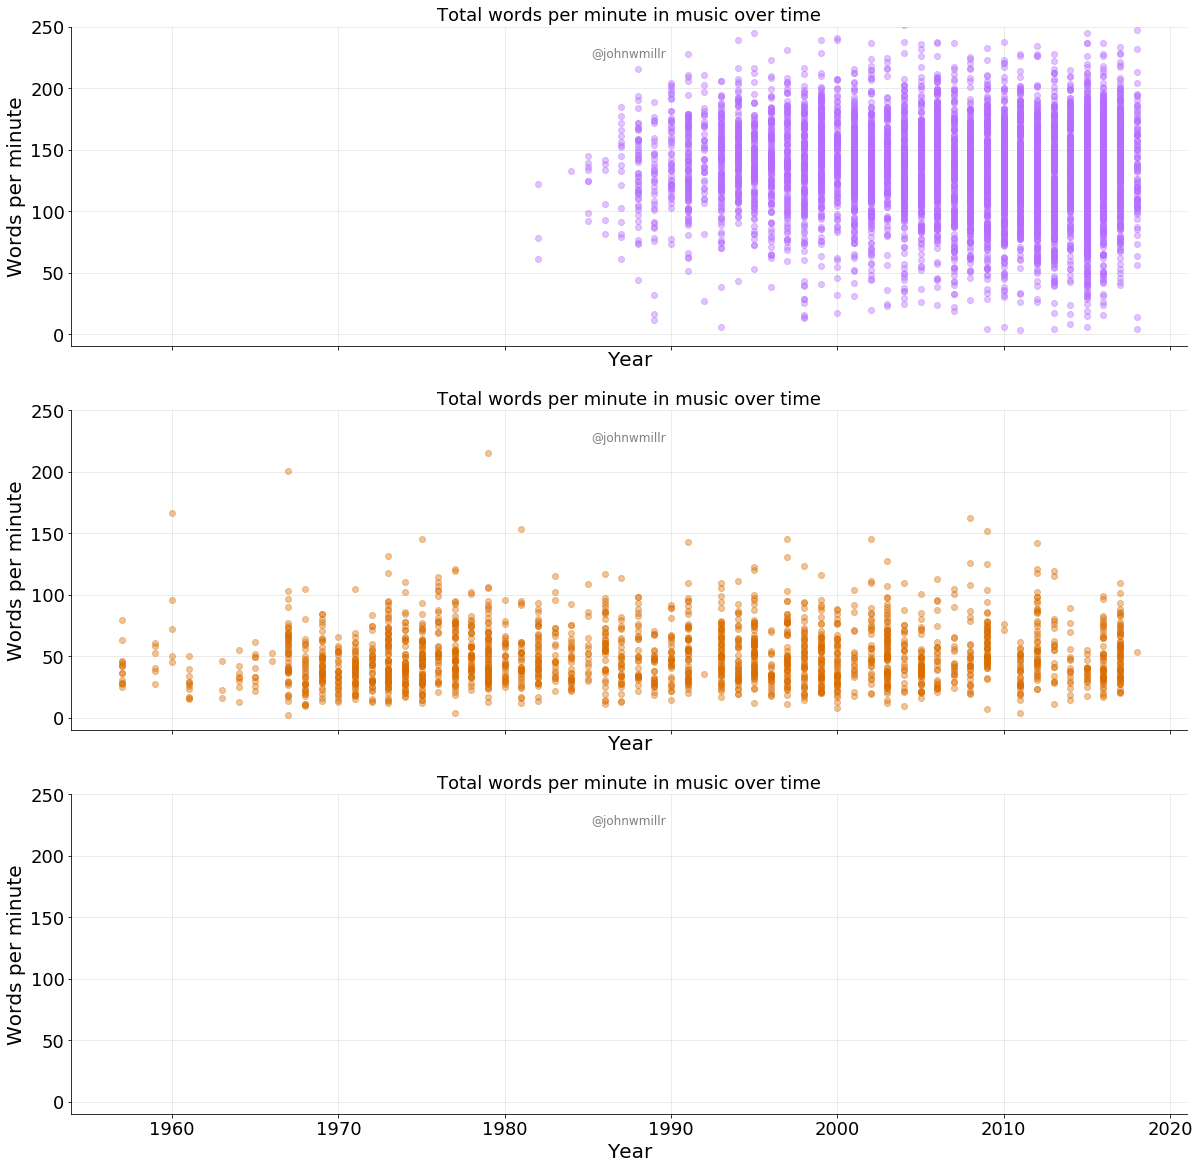

In [131]:
# http://kaylinwalker.com/50-years-of-pop-music/
# Plot the data
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
genres = ['rap','rock','country']

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(20,20))
for n,ax in enumerate(axs):
    years = np.array(list(map(lambda d: d.year, [s['date'] for s in songs_with_year if s['genre'] == genres[n]])))
    songs_w_year = np.array([x for _, x in sorted(zip(years, songs_with_year), key=lambda pair: pair[0])]).copy()
    wpm_w_year = np.array([x for _, x in sorted(zip(years, wpm_with_year), key=lambda pair: pair[0])]).copy()
    years.sort()
    
    mask_genre = np.array([j for j,song in enumerate(songs_w_year) if song['genre']==genres[n]])    
    if len(mask_genre) > 0:
        y = wpm_w_year[mask_genre]
        years = years[mask_genre]
        ax.plot(years, y, 'o', color=colors[n], alpha=0.4, markersize=6)
#         y_fit, t, r2 = fitLine(years, np.array())
#         ax.plot(t, y_fit, 'k', linewidth=2)

# Touch up the plot

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.set_xlim([1984, 2019])
    ax.set_ylim([-10, 250])
    ax.set_title("Total words per minute in music over time", fontsize=FS+2)
    ax.set_xlabel("Year", fontsize=FS+4)
    ax.set_ylabel("Words per minute", fontsize=FS+4)
    ax.tick_params(labelsize=FS+2, labelcolor='k', color='k')
    ax.annotate("@johnwmillr", (1985.2,225), fontsize=FS-4, alpha=0.5)
    ax.grid(True, alpha=0.3)

    # plt.savefig('./figures/TimePlot_words_per_minute_all.png', bbox_inches='tight', dpi=300)
plt.show()

In [126]:
songs_with_year[-1]['genre']

'country'

# Interactive plots

In [323]:
import mpld3
from mpld3 import plugins
%matplotlib inline
mpld3.enable_notebook()

In [294]:
# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: center;
}
img
{
    border-radius: 8px;
    height: auto;        
}
center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
"""

In [320]:
# Extract data values
all_dates = [song['date'] for song in songs_with_year]
all_wcs   = [song['word_count'] for song in songs_with_year]
all_wpm   = [song['wpm'] for song in songs_with_year]
all_lexdivs = [song['lexdiv'] for song in songs_with_year]
all_titles  = [song['title'] for song in songs_with_year]
all_artists = [song['spotify']['artists'][0]['name'] for song in songs_with_year]
all_images = [song['spotify']['album']['images'][0]['url'] for song in songs_with_year]

In [406]:
# Create the data tips
df = pd.DataFrame({'artist': all_artists, 'year': all_dates, 'word_count': all_wcs, 'wpm': all_wpm, 'lexdiv': all_lexdivs})
names = all_titles
imgs = ['<img src="{}" width="80">'.format(url) for url in all_images]
labels = []
for i in range(len(df)):
    label = df.iloc[[i], :].T    
    label.columns = [names[i]]
    html = label.drop([], axis=0).to_html() + '\n' + imgs[i]
    labels.append(html)

# --------------------------
# Do the actual plotting
# Scatter plot the data
fig, ax = plt.subplots(figsize=(12,10))
ax.grid(True, alpha=0.3)

term1,term2 = 'year','lexdiv'

x,y = df[term1],df[term2]
b = []
ms = 5
for color in ['r']:
    b.append(plt.plot(x, y, color+'o', ms=ms, alpha=0.2, label='rap'))

# https://mpld3.github.io/examples/html_tooltips.html
points = ax.plot(df[term1], df[term2], 'ko', mec='k', ms=ms, alpha=0.0, label="") # Plot all of the data
tooltip = plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

ax.set_xlabel(term1, fontsize=FS)
ax.set_ylabel(term2, fontsize=FS)
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS-2) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FS-2)
# ax.set_title("Pitchfork album review scores as a function of lexical diversity", fontsize=FS)
ax.annotate("@johnwmillr", (0.2,.8), fontsize=FS-4, alpha=0.5)
# ax.legend(loc=(0.8,.2), frameon=True, facecolor='w', edgecolor='k', fontsize=FS-4, framealpha=0.4)
# ax.set_xlim([datetime.strptime('1984', '%Y'), datetime.strptime('2019', '%Y')])
# ax.set_ylim([-10, 250])

mpld3.display()
# plotname = 'mpld3_{}_vs_{}'.format('lexdiv','score')
# mpld3.save_html(fig, './figures/'+plotname+'.html', figid=plotname, template_type='simple')

# Should be using data frames

In [ ]:
# http://jdaytn.com/posts/download-blink-182-data/
df = pd.DataFrame(columns=[
    'name',
    'duration_ms',
    'popularity',
    'num_markets',
    'album',
    'disc_number',
    'is_explicit',
    'track_number',
    'release_date',
    'artist',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
])
for album_info, album_features in zip(
        spotify_data.get('tracks'), 
        spotify_data.get('audio_features')
        ):
    for track_info, track_features in zip(
        album_info.get('tracks'),
        album_features
        ):
        y = {
            'name': track_info['name'],
            'duration_ms': track_info['duration_ms'],
            'popularity': track_info['popularity'],
            'num_markets': len(track_info['available_markets']),
            'album': track_info['album']['name'],
            'disc_number': track_info['disc_number'],
            'is_explicit': track_info['explicit'],
            'track_number': track_info['track_number'],
            'release_date': track_info['album']['release_date'],
            'artist': track_info['artists'][0]['name'],
            'danceability': track_features['danceability'],
            'energy': track_features['energy'],
            'key': track_features['key'],
            'loudness': track_features['loudness'],
            'mode': track_features['mode'],
            'speechiness': track_features['speechiness'],
            'acousticness': track_features['acousticness'],
            'instrumentalness': track_features['instrumentalness'],
            'liveness': track_features['liveness'],
            'valence': track_features['valence'],
            'tempo': track_features['tempo'],
            'time_signature': track_features['time_signature'],
        }
        df = df.append(y, ignore_index=True)
info_path = "~/Documents/datasets/bl182/spotify.csv"
df.to_csv(info_path, index=False)
print(df.iloc[0])